## **Bootstrap Your Own Latent A New Approach to Self-Supervised Learning:** https://arxiv.org/pdf/2006.07733.pdf

In [ ]:
# !pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
# !pip install -qqU fastai fastcore

In [ ]:
# !pip install nbdev

In [ ]:
import fastai, fastcore, torch

In [ ]:
fastai.__version__ , fastcore.__version__, torch.__version__

('2.0.8', '1.0.1', '1.6.0+cu101')

In [ ]:
from fastai.vision.all import *

### Sizes

Resize -> RandomCrop

320 -> 256 | 224 -> 192 | 160 -> 128

In [ ]:
resize = 320
size = 256

## 1. Implementation Details (Section 3.2 from the paper)

### 1.1 Image Augmentations

Same as SimCLR with optional grayscale

In [ ]:
import kornia
def get_aug_pipe(size, stats=imagenet_stats, s=.6):
    "SimCLR augmentations"
    rrc = kornia.augmentation.RandomResizedCrop((size, size), scale=(0.2, 1.0), ratio=(3/4, 4/3))
    rhf = kornia.augmentation.RandomHorizontalFlip()
    rcj = kornia.augmentation.ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s)
    rgs = kornia.augmentation.RandomGrayscale(p=0.2)
    
    tfms = [rrc, rhf, rcj, rgs, Normalize.from_stats(*stats)]
    pipe = Pipeline(tfms)
    pipe.split_idx = 0
    return pipe

### 1.2 Architecture

In [ ]:
def create_encoder(arch, n_in=3, pretrained=True, cut=None, concat_pool=True):
    "Create encoder from a given arch backbone"
    encoder = create_body(arch, n_in, pretrained, cut)
    pool = AdaptiveConcatPool2d() if concat_pool else nn.AdaptiveAvgPool2d(1)
    return nn.Sequential(*encoder, pool, Flatten())

In [ ]:
class MLP(Module):
    "MLP module as described in paper"
    def __init__(self, dim, projection_size=256, hidden_size=2048):
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_size, projection_size)
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
class BYOLModel(Module):
    "Compute predictions of v1 and v2" 
    def __init__(self,encoder,projector,predictor):
        self.encoder,self.projector,self.predictor = encoder,projector,predictor    

    def forward(self,v1,v2):
        q1 = self.predictor(self.projector(self.encoder(v1)))
        q2 = self.predictor(self.projector(self.encoder(v2)))
        return (q1,q2)

In [ ]:
def create_byol_model(arch=resnet50, hidden_size=4096, pretrained=True, projection_size=256, concat_pool=False):
    encoder = create_encoder(arch, pretrained=pretrained, concat_pool=concat_pool)
    with torch.no_grad(): 
        x = torch.randn((2,3,128,128))
        representation = encoder(x)

    projector = MLP(representation.size(1), projection_size, hidden_size=hidden_size)     
    predictor = MLP(projection_size, projection_size, hidden_size=hidden_size)
    apply_init(projector)
    apply_init(predictor)
    return BYOLModel(encoder, projector, predictor)

### 1.3 BYOLCallback

In [ ]:
def _mse_loss(x, y):
    x = F.normalize(x, dim=-1, p=2)
    y = F.normalize(y, dim=-1, p=2)
    return 2 - 2 * (x * y).sum(dim=-1)

def symmetric_mse_loss(pred, *yb):
    (q1,q2),z1,z2 = pred,*yb
    return (_mse_loss(q1,z2) + _mse_loss(q2,z1)).mean()

In [ ]:
x = torch.randn((64,256))
y = torch.randn((64,256))
test_close(symmetric_mse_loss((x,y),y,x), 0) # perfect
test_close(symmetric_mse_loss((x,y),x,y), 4, 1e-1) # random

Useful Discussions and Supportive Material:

- https://www.reddit.com/r/MachineLearning/comments/hju274/d_byol_bootstrap_your_own_latent_cheating/fwohtky/
- https://untitled-ai.github.io/understanding-self-supervised-contrastive-learning.html

In [ ]:
import copy

class BYOLCallback(Callback):
    "Implementation of https://arxiv.org/pdf/2006.07733.pdf"
    def __init__(self, T=0.99, debug=True, size=224, **aug_kwargs):        
        self.T, self.debug = T, debug
        self.aug1 = get_aug_pipe(size, **aug_kwargs)
        self.aug2 = get_aug_pipe(size, **aug_kwargs)


    def before_fit(self):
        "Create target model"
        self.target_model = copy.deepcopy(self.learn.model).to(self.dls.device)        
        self.T_sched = SchedCos(self.T, 1) # used in paper
        # self.T_sched = SchedNo(self.T, 1) # used in open source implementation
  
        
    def before_batch(self):
        "Generate 2 views of the same image and calculate target projections for these views"
        if self.debug: print(f"self.x[0]: {self.x[0]}")
        
        v1,v2 = self.aug1(self.x), self.aug2(self.x.clone())
        self.learn.xb = (v1,v2)
        
        if self.debug:
            print(f"v1[0]: {v1[0]}\nv2[0]: {v2[0]}")
            self.show_one()
            assert not torch.equal(*self.learn.xb)

        with torch.no_grad():
            z1 = self.target_model.projector(self.target_model.encoder(v1))
            z2 = self.target_model.projector(self.target_model.encoder(v2))
            self.learn.yb = (z1,z2)


    def after_step(self):
        "Update target model and T"
        self.T = self.T_sched(self.pct_train)
        with torch.no_grad():
            for param_k, param_q in zip(self.target_model.parameters(), self.model.parameters()):
                param_k.data = param_k.data * self.T + param_q.data * (1. - self.T)
          

    def show_one(self):
        b1 = self.aug1.normalize.decode(to_detach(self.learn.xb[0]))
        b2 = self.aug1.normalize.decode(to_detach(self.learn.xb[1]))
        i = np.random.choice(len(b1))
        show_images([b1[i],b2[i]], nrows=1, ncols=2)

    def after_train(self):      
        if self.debug: self.show_one()

    def after_validate(self):   
        if self.debug: self.show_one()

## 2. Pretext Training

In [ ]:
sqrmom=0.99
mom=0.95
beta=0.
eps=1e-4
opt_func = partial(ranger, mom=mom, sqr_mom=sqrmom, eps=eps, beta=beta)

In [ ]:
bs=128

In [ ]:
def get_dls(size, bs, workers=None):
    path = URLs.IMAGEWANG_160 if size <= 160 else URLs.IMAGEWANG
    source = untar_data(path)
    
    files = get_image_files(source)
    tfms = [[PILImage.create, ToTensor, RandomResizedCrop(size, min_scale=0.9)], 
            [parent_label, Categorize()]]
    
    dsets = Datasets(files, tfms=tfms, splits=RandomSplitter(valid_pct=0.1)(files))
    
    batch_tfms = [IntToFloatTensor]
    dls = dsets.dataloaders(bs=bs, num_workers=workers, after_batch=batch_tfms)
    return dls

In [ ]:
dls = get_dls(resize, bs)
model = create_byol_model(arch=xresnet34, pretrained=False)
learn = Learner(dls, model, symmetric_mse_loss, opt_func=opt_func,
                cbs=[BYOLCallback(T=0.99, size=size, debug=False), TerminateOnNaNCallback()])
learn.to_fp16();

SuggestedLRs(lr_min=0.017378008365631102, lr_steep=0.0010000000474974513)

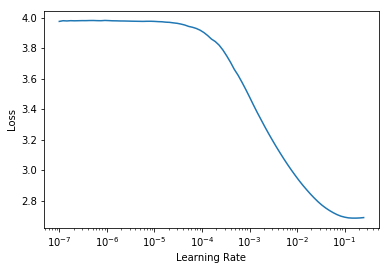

In [ ]:
learn.lr_find()

In [ ]:
lr=1e-3
wd=1e-2
epochs=100

In [ ]:
learn.unfreeze()
learn.fit_flat_cos(epochs, lr, wd=wd, pct_start=0.5)

epoch,train_loss,valid_loss,time
0,1.510650,1.428953,04:15
1,1.189431,1.137174,04:13
2,1.013760,1.007405,04:14
3,0.870598,0.874674,04:14
4,0.782515,0.789410,04:18
5,0.714516,0.736312,04:18
6,0.666287,0.775844,04:18
7,0.637795,0.718347,04:19
8,0.615426,0.657362,04:19
9,0.587785,0.708780,04:18


In [ ]:
save_name = f'byol_iwang_sz{size}_epc{epochs}'

In [ ]:
learn.save(save_name)
torch.save(learn.model.encoder.state_dict(), learn.path/learn.model_dir/f'{save_name}_encoder.pth')

In [ ]:
learn.load(save_name);

In [ ]:
lr=1e-4
wd=1e-2
epochs=100

In [ ]:
learn.unfreeze()
learn.fit_flat_cos(epochs, lr, wd=wd, pct_start=0.5)

epoch,train_loss,valid_loss,time
0,0.519158,0.628242,04:19
1,0.549050,0.726779,04:19
2,0.545667,0.614504,04:17
3,0.562666,0.669120,04:18
4,0.508613,0.688010,04:19
5,0.536102,0.744773,04:18
6,0.541971,0.726328,04:17
7,0.511115,0.628922,04:13
8,0.530850,0.678011,04:12
9,0.526052,0.656479,04:14


In [ ]:
save_name = f'byol_iwang_sz{size}_epc200'

In [ ]:
learn.save(save_name)
torch.save(learn.model.encoder.state_dict(), learn.path/learn.model_dir/f'{save_name}_encoder.pth')

In [ ]:
lr=1e-4
wd=1e-2
epochs=30

In [ ]:
learn.unfreeze()
learn.fit_flat_cos(epochs, lr, wd=wd, pct_start=0.5)

epoch,train_loss,valid_loss,time
0,0.528907,0.646549,04:13
1,0.530606,0.724795,04:12
2,0.518430,0.589998,04:15
3,0.529843,0.643619,04:16
4,0.542198,0.625090,04:16
5,0.528748,0.609527,04:16
6,0.535782,0.634512,04:16
7,0.531877,0.683111,04:15
8,0.519696,0.574612,04:16
9,0.530617,0.544109,04:16


In [ ]:
save_name = f'byol_iwang_sz{size}_epc230'

In [ ]:
learn.save(save_name)
torch.save(learn.model.encoder.state_dict(), learn.path/learn.model_dir/f'{save_name}_encoder.pth')

In [ ]:
lr=5e-5
wd=1e-2
epochs=30

In [ ]:
learn.unfreeze()
learn.fit_flat_cos(epochs, lr, wd=wd, pct_start=0.5)

In [ ]:
save_name = f'byol_iwang_sz{size}_epc260'

In [ ]:
learn.save(save_name)
torch.save(learn.model.encoder.state_dict(), learn.path/learn.model_dir/f'{save_name}_encoder.pth')

In [ ]:
learn.recorder.plot_loss()

In [ ]:
save_name

'byol_iwang_sz256_epc230'

## 3. Downstream Task - Image Classification

In [ ]:
def get_dls(size, bs, workers=None):
    path = URLs.IMAGEWANG_160 if size <= 160 else URLs.IMAGEWANG
    source = untar_data(path)
    files = get_image_files(source, folders=['train', 'val'])
    splits = GrandparentSplitter(valid_name='val')(files)
    
    item_aug = [RandomResizedCrop(size, min_scale=0.35), FlipItem(0.5)]
    tfms = [[PILImage.create, ToTensor, *item_aug], 
            [parent_label, Categorize()]]
    
    dsets = Datasets(files, tfms=tfms, splits=splits)
    
    batch_tfms = [IntToFloatTensor, Normalize.from_stats(*imagenet_stats)]
    dls = dsets.dataloaders(bs=bs, num_workers=workers, after_batch=batch_tfms)
    return dls

In [ ]:
def do_train(epochs=5, runs=5,  lr=2e-2, size=size, bs=bs, save_name=None):
    dls = get_dls(size, bs)
    for run in range(runs):
        print(f'Run: {run}')
        learn = cnn_learner(dls, xresnet34, opt_func=opt_func, normalize=False,
                metrics=[accuracy,top_k_accuracy], loss_func=LabelSmoothingCrossEntropy(),
                pretrained=False)
#         learn.to_fp16()
        
        if save_name is not None:
            state_dict = torch.load(learn.path/learn.model_dir/f'{save_name}_encoder.pth')
            learn.model[0].load_state_dict(state_dict)
            print("Model loaded...")
            
        learn.unfreeze()
        learn.fit_flat_cos(epochs, lr, wd=wd)

### ImageWang Leaderboard

**sz-256**



**Contrastive Learning**

- 5 epochs:  67.70%
- 20 epochs: 70.03%
- 80 epochs: 70.71%
- 200 epochs: 71.78%


**BYOL**

- 5 epochs: 64.74%
- 20 epochs: **71.01%**
- 80 epochs: **72.58%**
- 200 epochs: **72.13%**


### 5 epochs

In [ ]:
# we are using old pretrained model with size 192 for transfer learning
# link: https://github.com/KeremTurgutlu/self_supervised/blob/252269827da41b41091cf0db533b65c0d1312f85/nbs/byol_iwang_192.ipynb
save_name = 'byol_iwang_sz192_epc230'

In [ ]:
lr = 1e-2
wd=1e-2
bs=128
epochs = 5
runs = 5

In [ ]:
do_train(epochs, runs, lr=lr, bs=bs, save_name=save_name)

Run: 0
Model loaded...


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.391003,2.091779,0.427335,0.883431,01:30
1,1.126729,1.863697,0.508272,0.891066,01:30
2,1.041537,1.929433,0.500636,0.876050,01:30
3,1.000860,1.786491,0.550267,0.880631,01:30
4,0.887278,1.526213,0.657165,0.930008,01:30


Run: 1
Model loaded...


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.409500,1.993958,0.466531,0.882413,01:30
1,1.115309,1.930350,0.485365,0.883431,01:31
2,1.045545,1.777895,0.535251,0.901756,01:29
3,0.992903,1.793896,0.551285,0.909901,01:30
4,0.889791,1.577747,0.637312,0.929244,01:29


Run: 2
Model loaded...


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.372096,2.030257,0.441843,0.861797,01:30
1,1.124751,1.903099,0.495546,0.889539,01:29
2,1.052113,1.827768,0.517689,0.904810,01:30
3,1.004309,1.782487,0.548486,0.900484,01:29
4,0.911459,1.576011,0.631967,0.933316,01:30


Run: 3
Model loaded...


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.388013,1.947444,0.468567,0.876813,01:30
1,1.138622,1.827905,0.532451,0.903283,01:30
2,1.078687,1.856698,0.525070,0.876813,01:30
3,1.033799,1.874331,0.509544,0.890303,01:30
4,0.911943,1.542056,0.646729,0.932553,01:29


Run: 4
Model loaded...


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.365908,1.891052,0.499109,0.886485,01:29
1,1.130437,1.819628,0.524306,0.884449,01:29
2,1.058648,1.709278,0.576228,0.911937,01:30
3,1.025294,1.846014,0.525834,0.907610,01:30
4,0.897821,1.503069,0.664291,0.932807,01:29


In [ ]:
np.mean([0.657165,0.637312,0.631967,0.646729,0.664291])

0.6474928

### 20 epochs

In [ ]:
lr=2e-2
epochs = 20
runs = 3

In [ ]:
do_train(epochs, runs, lr=lr, save_name=save_name)

Run: 0
Model loaded...


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.394857,2.268882,0.362179,0.816238,01:30
1,1.250595,2.007836,0.441079,0.847544,01:30
2,1.197666,1.981842,0.435225,0.890557,01:30
3,1.178281,2.283340,0.363960,0.809112,01:30
4,1.079914,2.048681,0.447697,0.842708,01:30
5,1.029400,1.822048,0.520234,0.880122,01:30
6,0.999156,1.931383,0.490965,0.862815,01:30
7,0.950720,1.722235,0.564266,0.912700,01:31
8,0.925281,1.785434,0.554849,0.913973,01:30
9,0.910516,1.705481,0.588954,0.892339,01:29


Run: 1
Model loaded...


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.396147,2.352397,0.308984,0.789259,01:29
1,1.211235,2.210926,0.381777,0.829728,01:28
2,1.163799,2.104971,0.415118,0.831255,01:28
3,1.131004,2.178773,0.407228,0.817256,01:28
4,1.059999,2.143348,0.409264,0.857725,01:28
5,1.026634,2.056903,0.440825,0.832018,01:27
6,0.973074,1.927981,0.502927,0.886740,01:27
7,0.949476,1.829196,0.532451,0.892848,01:27
8,0.919149,1.717618,0.580300,0.902774,01:28
9,0.909597,1.691422,0.576483,0.911428,01:27


Run: 2
Model loaded...


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.414950,2.177913,0.367524,0.831764,01:27
1,1.215868,2.084969,0.413337,0.856452,01:27
2,1.160794,2.215767,0.394502,0.798422,01:28
3,1.103339,2.063161,0.432426,0.850089,01:27
4,1.034577,1.835640,0.511835,0.903538,01:27
5,1.000270,1.676985,0.575464,0.931789,01:27
6,0.959487,1.691361,0.570629,0.908628,01:28
7,0.943315,1.799891,0.546195,0.906847,01:27
8,0.925966,1.657880,0.597353,0.914228,01:28
9,0.895879,1.921196,0.512344,0.883685,01:27


In [ ]:
np.mean([0.711631, 0.705269, 0.713413])

0.7101043333333333

### 80 epochs

In [ ]:
epochs = 80
runs = 1

In [ ]:
do_train(epochs, runs, save_name=save_name)

Run: 0
Model loaded...


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.432139,2.193268,0.389667,0.822347,01:27
1,1.197331,2.040368,0.457877,0.869432,01:28
2,1.140320,2.065905,0.434971,0.833291,01:28
3,1.079537,2.285829,0.366760,0.780860,01:28
4,1.028553,1.889869,0.505218,0.874523,01:27
5,0.982782,1.932606,0.504709,0.874268,01:28
6,0.954037,1.926916,0.494273,0.869941,01:27
7,0.924774,1.748468,0.578010,0.905065,01:28
8,0.913467,1.764108,0.563502,0.919318,01:28
9,0.899805,1.687788,0.593281,0.915246,01:28


### 200 epochs

In [ ]:
epochs = 200
runs = 1

In [ ]:
do_train(epochs, runs, save_name=save_name)

Run: 0
Model loaded...


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.419125,2.284880,0.369814,0.811911,01:28
1,1.211017,2.350174,0.315856,0.819038,01:28
2,1.153036,1.992249,0.446424,0.873759,01:28
3,1.085376,1.840743,0.503181,0.895393,01:28
4,1.022951,2.173820,0.395266,0.836345,01:27
5,0.989262,1.895496,0.511581,0.879868,01:28
6,0.967016,1.675152,0.583864,0.913719,01:27
7,0.946929,1.838096,0.516162,0.907356,01:28
8,0.922163,1.730152,0.566556,0.919318,01:29
9,0.903864,1.832088,0.549249,0.873505,01:28
